In [1]:
import numpy as np
import matplotlib.pyplot as plt

In [2]:
# importing the data into arrays
# first column of the data file is phase data
LTPhaseHalf = np.loadtxt("GD356LT.dat", usecols=(0))
LTPhase = np.concatenate((LTPhaseHalf, LTPhaseHalf+1))
# second column of the data file is flux data
LTFluxHalf = np.loadtxt("GD356LT.dat", usecols=(1))
LTFlux = np.concatenate((LTFluxHalf+1, LTFluxHalf+1))
# third column of the data file is flux error
LTErrorHalf = np.loadtxt("GD356LT.dat", usecols=(2))
LTError = np.concatenate((LTErrorHalf, LTErrorHalf))

In [6]:
def mean_data(Phase, Flux, Error, bins):

    Phase_split = np.array_split(Phase, bins)
    Flux_split = np.array_split(Flux, bins)
    Error_split = np.array_split(Error, bins)

    meanPhase = [] * bins
    meanFlux = [] * bins
    meanError = [] * bins

    for i in range(bins):

        meanPhase_i = np.mean(Phase_split[i])
        meanFlux_i = np.sum(Flux_split[i] / (Error_split[i]**2))/ np.sum(1/(Error_split[i]**2))

        meanError_i = np.sqrt(1/np.sum(1/(Error_split[i]**2)))

        meanPhase.append(meanPhase_i)
        meanFlux.append(meanFlux_i)
        meanError.append(meanError_i)
        
    return meanPhase, meanFlux, meanError

meanPhase, meanFlux, meanError = mean_data(LTPhase, LTFlux, LTError, 200)

In [3]:
import numpy as np
import starry
import exoplanet as xo
import pymc3 as pm
import pymc3_ext as pmx
import matplotlib.pyplot as plt

starry.config.lazy = True
starry.config.quiet = True

In [7]:
flux = meanFlux/np.amin(meanFlux)
flux_err = np.mean(meanError)/np.amin(meanFlux)
t = meanPhase
theta = np.multiply(meanPhase, 360)

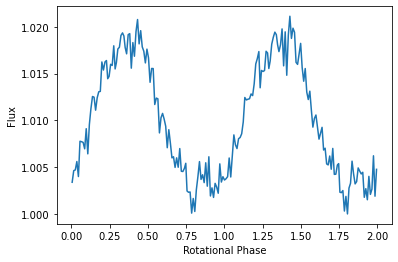

In [8]:
plt.plot(t, flux)
plt.xlabel("Rotational Phase")
plt.ylabel("Flux");

In [9]:
with pm.Model() as model:

    # Priors
    contrast1 = pm.Uniform("contrast1", lower=-1.0, upper=0.0, testval=-0.3)
    radius1 = pm.Uniform("radius1", lower=10.0, upper=50.0, testval=15.0)
    contrast2 = pm.Uniform("contrast2", lower=-1.0, upper=0.0, testval=-0.3)
    radius2 = pm.Uniform("radius2", lower=0.0, upper=50.0, testval=15.0)
    lat = pm.Uniform("lat", lower=-90.0, upper=90.0, testval=0.1)
    lon = pm.Uniform("lon", lower=-180.0, upper=180.0, testval=0.1)
    inc = pm.Uniform("inc", lower=0.0, upper=90.0, testval=0.1)
    
    
    # Instantiate the map and add the spot
    map = starry.Map(ydeg=30)
    map.inc = inc
    map.spot(contrast=contrast1, radius=radius1, lat=lat, lon=lon)
    map.spot(contrast=contrast2, radius=radius2, lat=-lat, lon=lon+180)

    # Compute the flux model
    flux_model = map.flux(theta=theta)
    pm.Deterministic("flux_model", flux_model)

    # Save our initial guess
    flux_model_guess = pmx.eval_in_model(flux_model)

    # The likelihood function assuming known Gaussian uncertainty
    pm.Normal("obs", mu=flux_model, sd=flux_err, observed=flux)

In [10]:
with model:
    map_soln = pmx.optimize(start=model.test_point)

optimizing logp for variables: [inc, lon, lat, radius2, contrast2, radius1, contrast1]


message: Desired error not necessarily achieved due to precision loss.
logp: -3215.668330045381 -> 1015.8376858945971


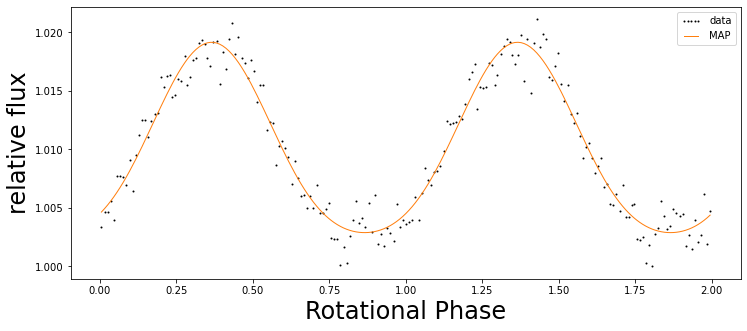

In [11]:
plt.figure(figsize=(12, 5))
plt.plot(t, flux, "k.", alpha=1, ms=2, label="data")
plt.plot(
    t, pmx.eval_in_model(flux_model, map_soln, model=model), "C1-", label="MAP", lw=1
)
plt.legend(fontsize=10, numpoints=5)
plt.xlabel("Rotational Phase", fontsize=24)
plt.ylabel("relative flux", fontsize=24);

In [12]:
keys = ["contrast1", "radius1", "contrast2", "radius2", "lat", "lon", "inc"]

In [13]:
param = []
print("{0:12s} {1:10s}".format("", "map_soln"))
for key in keys:
    print("{0:10s} {1:10.5f}".format(key, map_soln[key]))
    param.append(map_soln[key])

             map_soln  
contrast1    -0.01135
radius1      17.80979
contrast2    -0.28269
radius2      40.01930
lat          11.83966
lon          48.43606
inc          12.18525


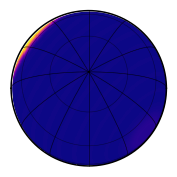

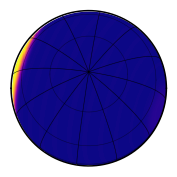

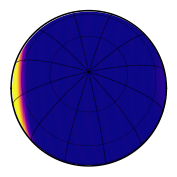

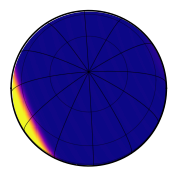

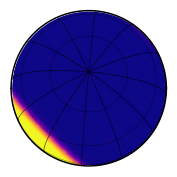

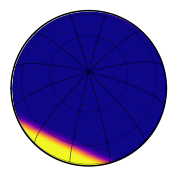

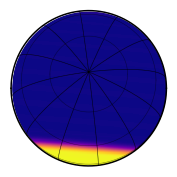

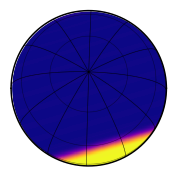

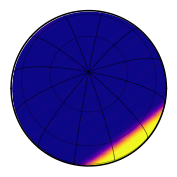

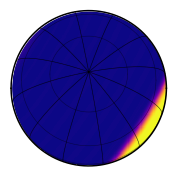

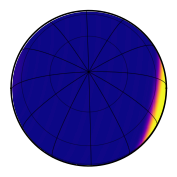

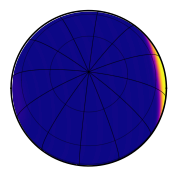

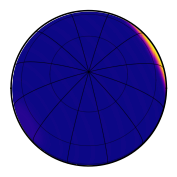

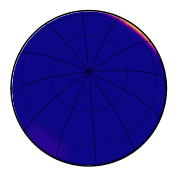

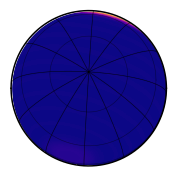

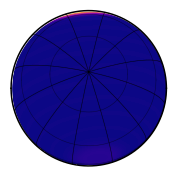

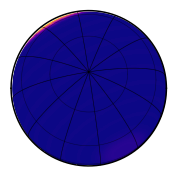

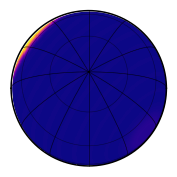

In [14]:
starry.config.lazy = False

map = starry.Map(ydeg=30)
map.spot(contrast=param[0], radius=param[1], lat=param[4], lon=param[5])
map.spot(contrast=param[2], radius=param[3], lat=-param[4], lon=param[5]+180)
map.inc = param[6]

x = np.linspace(0, 360, 18, endpoint=True)
for angle in x:
    map.show(theta=angle)